In [688]:
import os
import pandas as pd
import numpy as np
from collections import deque
from io import StringIO
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.cluster import AffinityPropagation

from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import normalized_mutual_info_score

import matplotlib.pyplot as plt

%matplotlib inline

# Affinity Propagation на матрицах, для оценки адекватности алгоритма на графах

In [490]:
class CustomAffinityPropagation(object):
    def __init__(self, similarity_measure = None):
        if similarity_measure is None:
            self.similarity_measure = lambda x, y: -np.power(x - y, 2).sum()
        else: 
            self.similarity_measure = similarity_measure
        
        self.S = None
        self.A = None
        self.R = None
    
    def load_similarity_matrix(self, S_new):
        self.S = S_new
        if hasattr(self.S, 'todense'):
            self.A = csr_matrix((S_new.shape[0], S_new.shape[0]))
            self.R = csr_matrix((S_new.shape[0], S_new.shape[0]))
        else:
            self.A = np.zeros_like(S_new)
            self.R = np.zeros_like(S_new)
        
    def calc_similarity_matrix(self, X):
        self.S = np.zeros((X.shape[0], X.shape[0]))
        self.A = np.zeros_like(self.S)
        self.R = np.zeros_like(self.S)
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                self.S[i, j] = self.similarity_measure(X[i,:], X[j,:])
                
        self.S[np.diag_indices_from(self.S)] = np.median(self.S)#np.random.normal(loc=-5, scale=2) / 1e-8
        
        return self.S
    
    def update_responsibility(self, damping=.9):
        # For every column k, except for the column with the maximum value the max is the same.
        # So we can subtract the maximum for every row, 
        # and only need to do something different for k == argmax

        v = self.S + self.A
        rows = np.arange(self.S.shape[0])
        # We only compare the current point to all other points, 
        # so the diagonal can be filled with -infinity
        np.fill_diagonal(v, -np.inf)

        # max values
        idx_max = np.argmax(v, axis=1)
        first_max = v[rows, idx_max]

        # Second max values. For every column where k is the max value.
        v[rows, idx_max] = -np.inf
        second_max = v[rows, np.argmax(v, axis=1)]

        # Broadcast the maximum value per row over all the columns per row.
        max_matrix = np.zeros_like(self.R) + first_max[:, None]
        max_matrix[rows, idx_max] = second_max

        new_val = self.S - max_matrix

        self.R = self.R * damping + (1 - damping) * new_val

        
    def update_availability(self, damping=0.9):
        k_k_idx = np.arange(self.S.shape[0])
        # set a(i, k)
        a = np.array(self.R)
        a[a < 0] = 0
        np.fill_diagonal(a, 0)
        a = a.sum(axis=0) # columnwise sum
        a = a + self.R[k_k_idx, k_k_idx]

        # broadcasting of columns 'r(k, k) + sum(max(0, r(i', k))) to rows.
        a = np.ones(self.A.shape) * a

        # For every column k, subtract the positive value of k. 
        # This value is included in the sum and shouldn't be
        a -= np.clip(self.R, 0, np.inf)
        a[a > 0] = 0

        # set(a(k, k))
        w = np.array(self.R)
        np.fill_diagonal(w, 0)

        w[w < 0] = 0

        a[k_k_idx, k_k_idx] = w.sum(axis=0) # column wise sum
        self.A = self.A * damping + (1 - damping) * a
    
    
    def fit_transform(self, X=None, y=None):
        if X is not None:
            self.calc_similarity_matrix(X)
            
        for i in range(1000):
            self.update_responsibility(.9)
            self.update_availability(.9)
        
        clusters = np.argmax(self.A + self.R, axis=1)
        return clusters
            

In [491]:
X, y = make_blobs(n_samples=100, centers=5, n_features=2, random_state=42)

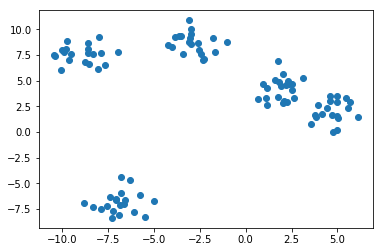

In [492]:
plt.scatter(x = X[:, 0], y = X[:, 1])

In [493]:
afine = CustomAffinityPropagation()
clusters = afine.fit_transform(X)
np.unique(clusters)#.shape

array([ 2, 11, 41, 48, 71, 78], dtype=int64)

In [494]:
unique_clust = np.unique(clusters).tolist()
mapping = dict(zip(unique_clust, range(len(unique_clust))))
mapped_clusters = np.array(list(map(lambda x: mapping[x], clusters.tolist())))

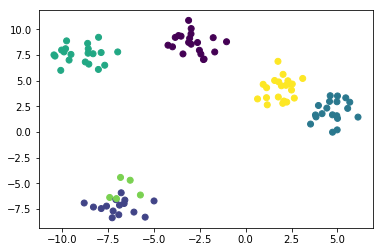

In [495]:
plt.scatter(x = X[:, 0], y = X[:, 1], c=mapped_clusters)#, cmap='tab20')

# Синтетика для теста алгоритма на графах

In [505]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42)
synth = CustomAffinityPropagation().calc_similarity_matrix(X)
np.fill_diagonal(synth, 0)

outp_data = ''
for i in range(synth.shape[0]):
    for j in range(synth.shape[1]):
        if synth[i, j] != 0:
            outp_data += f"{i}\t{j}\t{synth[i, j]}\n"
            
with open("./Gowalla/synth.txt", "w") as f:
    f.write(outp_data)

In [548]:
rawdata = None
with open('./Gowalla/exemplars.txt', 'r') as f:
    rawdata = f.read()
    
clusters = pd.read_csv(StringIO(rawdata), sep='\t', header=None)

In [549]:
unique_clust = np.unique(clusters[1]).tolist()
mapping = dict(zip(unique_clust, range(len(unique_clust))))
mapped_clusters = np.array(list(map(lambda x: mapping[x], clusters[1].tolist())))

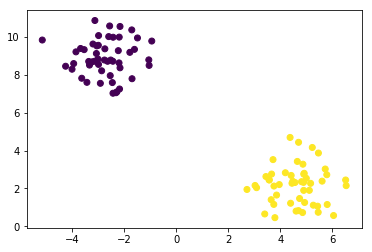

In [550]:
plt.scatter(x = X[:, 0], y = X[:, 1], c=mapped_clusters)#, cmap='tab20')

# Gowalla

# Загружаем результат кластеризации (Gowalla)

In [807]:
rawdata = None
with open('./Gowalla/exemplars.txt', 'r') as f:
    rawdata = f.read()
    
clusters = pd.read_csv(StringIO(rawdata), sep='\t', header=None)#.rename('node', 'exemplar')
clusters.columns = ['node', 'exemplar']

In [808]:
rawdata = None
with open('./Gowalla/nodes_outputs.txt', 'r') as f:
    rawdata = f.read()
    
nodes_outputs = pd.read_csv(StringIO(rawdata), sep='\t', header=None)#.rename('node', 'exemplar')
nodes_outputs.columns = ['node', 'outputs']

In [809]:
nodes_outputs['cluster'] = clusters.exemplar

In [810]:
exemplars = clusters.exemplar.tolist()

In [811]:
# транзитивное замыкание

for ix_node, record in enumerate(exemplars):
    flow = list()
    flow.append(ix_node)
    flow.append(record)
    
    while record not in flow:
        record = exemplars[record]
        flow.append(record)
    
    if len(flow) > 2:
        print(flow)
    
    #if record != exemplars[ix_node]:
    #    print(f'transitive for {ix_node}')
    #    exemplars[ix_node] = record

In [812]:
# транзитивное замыкание не понадобилось

In [813]:
clusters_sizes = clusters.exemplar.value_counts()

In [814]:
print('количество малых кластеров', np.sum(clusters_sizes <= 2), f'покрытие: ', clusters_sizes[clusters_sizes <= 2].sum() / clusters_sizes.sum())

количество малых кластеров 53749 покрытие:  0.32577279733049835


In [815]:
print('количество крупных кластеров', np.sum(clusters_sizes > 2), f'покрытие: ', clusters_sizes[clusters_sizes > 2].sum() / clusters_sizes.sum())

количество крупных кластеров 15507 покрытие:  0.6742272026695016


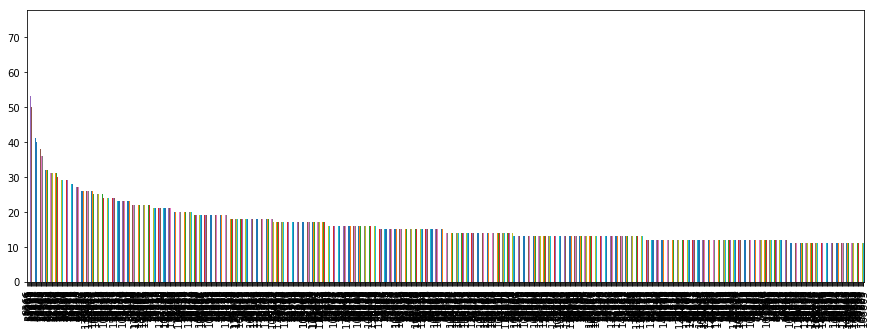

In [817]:
nodes_outputs[nodes_outputs.cluster.isin(clusters_sizes[clusters_sizes <= 2].index)].outputs.sort_values(ascending=False).iloc[:1000].plot(kind='bar', figsize=(15, 5))

In [818]:
print('первые 500 кластеров по объему')
print(clusters.exemplar.value_counts())

первые 500 кластеров по объему
220       10186
440        3585
459        3148
207         978
1431        882
3           751
2196        731
1430        647
1791        557
2215        539
2089        469
1857        442
4370        441
38454       340
7480        268
1653        248
8037        232
1927        215
5568        213
2199        208
1605        208
47875       201
3673        180
1           171
68929       153
5849        153
8035        146
1994        145
1903        137
41281       133
          ...  
105483        1
103434        1
99336         1
117761        1
146431        1
47474         1
35188         1
181344        1
195687        1
70810         1
121987        1
91284         1
89235         1
92488         1
109709        1
103562        1
99464         1
128134        1
126085        1
117889        1
164968        1
140412        1
90441         1
160886        1
158837        1
156788        1
152690        1
175213        1
173164        1
106740   

# Анализируем чекины

In [588]:
rawdata = None
with open('./Gowalla/Gowalla_totalCheckins.txt', 'r') as f:
    rawdata = f.read()
    
checkins = pd.read_csv(StringIO(rawdata), sep='\t', header=None)
checkins.columns = ['user_from', 'time', 'latitude', 'longitude', 'user_to']
checkins.drop(['time', 'latitude', 'longitude'], inplace=True, axis=1)

In [589]:
def get_top_checkins(x):
    top_5 = x.user_to.value_counts().iloc[:10].index.values
    return pd.Series(top_5)

top_checkins = checkins.groupby('user_from').apply(get_top_checkins).unstack()

In [604]:
# в логах чекинов нет некоторых пользователей

In [667]:
top_checkins_corrected = top_checkins

In [668]:
top_checkins.shape[0], len(exemplars)

(107092, 196591)

In [774]:
top_checkins['cluster'] = clusters.exemplar

In [835]:
def get_relevant_checkin_share(x, share = .1):
    scores = []
    for i in range(10):
        def get_indices(n_samples):
            full_range = list(range(n_samples))

            random_boys = np.random.choice(full_range, size=int(n_samples * share), replace=False)
            difference = np.setdiff1d(full_range, random_boys)

            return random_boys, difference
        
        # скрываем некоторых пользователей
        random_boys, difference = get_indices(x.shape[0])
    
        test_users = x.iloc[random_boys]
        val_users = x.iloc[difference]
        
        # удаляем nan из выборки
        val_users_values = val_users.values.flatten()
        val_users_values = val_users_values[~np.isnan(val_users_values)]
        val_users_values = val_users_values.astype(int)
        test_users_values = test_users.values.flatten()
        test_users_values = test_users_values[~np.isnan(test_users_values)]
        test_users_values = test_users_values.astype(int)
        
        # считаем уникальные значения локация / количество пользователей на локацию (валидация)
        unique_users_val, counts_val = np.unique(val_users_values, return_counts=True)
        unique_users_val = unique_users_val.astype(int).tolist()
        counts_val = counts_val.astype(int).tolist()
        
        # синхронно сортируем оба массива по количеству пользователей на локацию
        sorted_data = list(zip(*sorted(zip(unique_users_val, counts_val), key=lambda x: -x[1])))
        
        unique_users_val = sorted_data[0]
        counts_val = sorted_data[1]
        
        # считаем уникальные значения локация / количество пользователей на локацию (скрытые пользователи)
        unique_users_test, counts_test = np.unique(test_users_values, return_counts=True)
        
        
        # маска вида [1 0 1 0 ...], попала локация в топ или нет
        mask = np.array([j in unique_users_test for j in unique_users_val])
        
        if mask.sum() == 0:
            scores.append(0)
        elif mask.sum() == 1:
            scores.append(1)
        else:
            # считаем auc roc, где маска - чекинился ли пользователь, 
            scores.append(roc_auc_score(mask, unique_users_val))
    
    return np.mean(scores)

ranking = top_checkins_corrected.groupby('cluster').apply(get_relevant_checkin_share)

In [836]:
print('кластеров с нулевым скором: ', (ranking == 0).sum())

кластеров с нулевым скором:  40572


In [837]:
print('кластеров с ненулевым скором: ', (ranking != 0).sum())

кластеров с ненулевым скором:  1063


In [838]:
print('средний скор по кластерам: ', ranking.mean())

средний скор по кластерам:  0.014258211318887475


In [842]:
print('средний скор по ненулевым кластерам: ', ranking[ranking != 0].mean())

средний скор по ненулевым кластерам:  0.5584577876405268


In [850]:
print('процент покрытия пользователей кластерами с ненулевым скором ', clusters_sizes.loc[ranking[ranking != 0].index].sum() / top_checkins.shape[0])

процент покрытия пользователей кластерами с ненулевым скором  0.5045474918761439


D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
